In [ ]:
!git clone https://github.com/esgario/lara2018.git

Cloning into 'lara2018'...
remote: Enumerating objects: 5950, done.
remote: Total 5950 (delta 0), reused 0 (delta 0), pack-reused 5950
Receiving objects: 100% (5950/5950), 116.88 MiB | 24.68 MiB/s, done.
Resolving deltas: 100% (451/451), done.
Updating files: 100% (5559/5559), done.


In [ ]:
import os
import glob
import cv2 as cv
import io
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import numpy as np

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
def make_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

Y_train_data_path = "/content/lara2018/segmentation/dataset/annotations/train"
Y_test_data_path = "/content/lara2018/segmentation/dataset/annotations/test"
X_train_data_path = "/content/lara2018/segmentation/dataset/images/train"
X_test_data_path = "/content/lara2018/segmentation/dataset/images/test"

def create_train_test_image_folders(path, file_extension, folder_name, is_mask = False):
  print("running for", folder_name)
  make_dir(folder_name)
  path_list = glob.glob(path+"/*." + file_extension)
  path_list = sorted(path_list)
  images_list = []
  for ind in tqdm(range(len(path_list)), total= len(path_list)):
    path = path_list[ind]
    img = cv.imread(path)[:,:,:IMG_CHANNELS]
    img = cv.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    # if(is_mask):
      # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      # p, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY)
      # img = cv.merge((img, img, img))
      # img = np.ndarray.flatten(img)
      # img = np.expand_dims(img, axis = -1)
      # img = img.astype('float32').reshape((-1,1))
    img = img.astype(float)
    # Map image to float
    # Divide all values by 255
    img /= 255.0
    image_name = path.split("/")[-1]
    images_list.append(img)
    save_path = os.path.join(os.getcwd(), folder_name, image_name)
    cv.imwrite(save_path, img)
  return images_list

In [ ]:
Y_train = np.array(create_train_test_image_folders(Y_train_data_path, 'png', "Y_train", is_mask = True))
X_train = np.array(create_train_test_image_folders(X_train_data_path, 'jpg', "X_train"))

running for Y_train


100%|██████████| 400/400 [00:11<00:00, 35.85it/s]


running for X_train


100%|██████████| 400/400 [00:13<00:00, 28.93it/s]


In [ ]:
Y_test = np.array(create_train_test_image_folders(Y_test_data_path, 'png', "Y_test", is_mask = True))
X_test = np.array(create_train_test_image_folders(X_test_data_path,  'jpg', "X_test"))

running for Y_test


100%|██████████| 50/50 [00:01<00:00, 32.97it/s]


running for X_test


100%|██████████| 50/50 [00:02<00:00, 24.16it/s]


In [ ]:
def multi_class_UNet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
  #   global IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS
  #Build the model
  inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
  # s = tf.keras.layers.Lambda(lambda x: x * 255)(inputs)

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
  p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

  c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
  c6 = tf.keras.layers.Dropout(0.3)(c6)
  c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  p6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c6)

  c7 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p6)
  c7 = tf.keras.layers.Dropout(0.3)(c7)
  c7 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)


  #Expansive path
  u8 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c6])
  c8 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.2)(c8)
  c8 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c5])
  c9 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.2)(c9)
  c9 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  u10 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c9)
  u10 = tf.keras.layers.concatenate([u10, c4])
  c10 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
  c10 = tf.keras.layers.Dropout(0.2)(c10)
  c10 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

  u11 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c10)
  u11 = tf.keras.layers.concatenate([u11, c3])
  c11 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
  c11 = tf.keras.layers.Dropout(0.2)(c11)
  c11 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

  u12 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c11)
  u12 = tf.keras.layers.concatenate([u12, c2])
  c12 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u12)
  c12 = tf.keras.layers.Dropout(0.1)(c12)
  c12 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c12)

  u13 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c12)
  u13 = tf.keras.layers.concatenate([u13, c1], axis=3)
  c13 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u13)
  c13 = tf.keras.layers.Dropout(0.1)(c13)
  c13 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c13)

  outputs = tf.keras.layers.Conv2D(3, 1, activation="relu")(c13)

  Unet_MultiClass_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  Unet_MultiClass_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return Unet_MultiClass_model


In [ ]:
#  model checkpoint
model = multi_class_UNet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose =1, save_best_only = True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience =4, monitor =  "val_accuracy"),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]
results2 = model.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 50, callbacks = callbacks)

Epoch 1/50
23/23 [==============================] - 196s 8s/step - loss: 0.8690 - accuracy: 0.4576 - val_loss: 0.6110 - val_accuracy: 0.6899
Epoch 2/50
23/23 [==============================] - 207s 9s/step - loss: 0.6179 - accuracy: 0.5979 - val_loss: 0.5722 - val_accuracy: 0.7421
Epoch 3/50
23/23 [==============================] - 195s 8s/step - loss: 0.5921 - accuracy: 0.5619 - val_loss: 0.5629 - val_accuracy: 0.7482
Epoch 4/50
23/23 [==============================] - 191s 8s/step - loss: 0.5973 - accuracy: 0.3804 - val_loss: 0.5589 - val_accuracy: 0.3467
Epoch 5/50
23/23 [==============================] - 185s 8s/step - loss: 0.5788 - accuracy: 0.4145 - val_loss: 0.5522 - val_accuracy: 0.3616
Epoch 6/50
23/23 [==============================] - 187s 8s/step - loss: 0.5699 - accuracy: 0.3985 - val_loss: 0.5463 - val_accuracy: 0.3737
Epoch 7/50
23/23 [==============================] - 190s 8s/step - loss: 0.5642 - accuracy: 0.4089 - val_loss: 0.5440 - val_accuracy: 0.3751


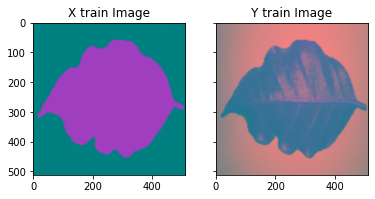

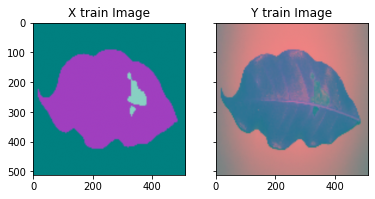

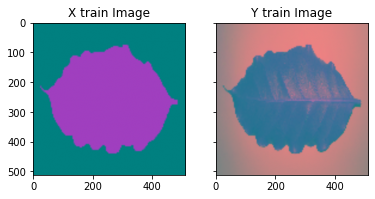

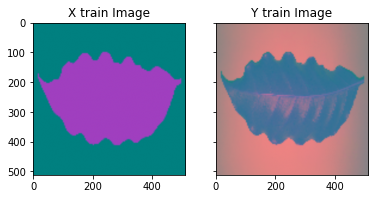

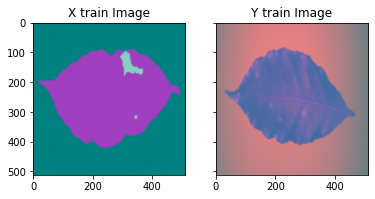

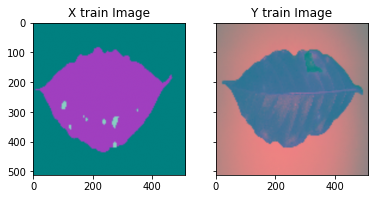

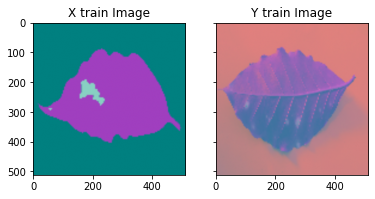

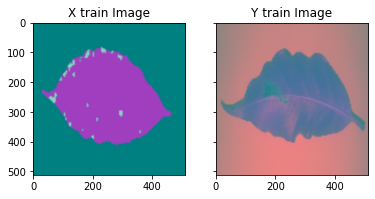

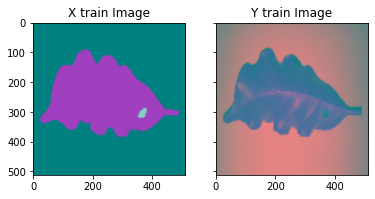

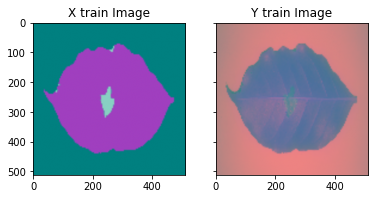

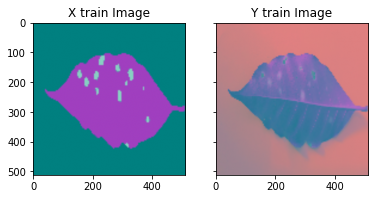

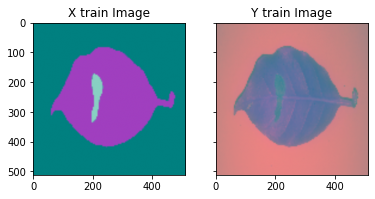

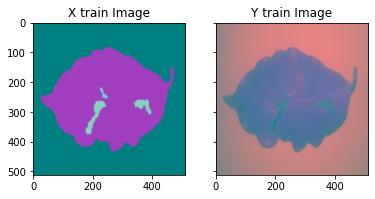

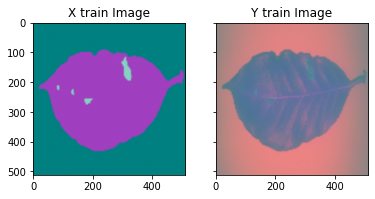

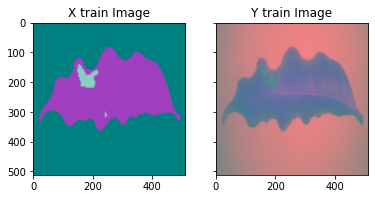

In [ ]:
import matplotlib.pyplot as plt

for i in range(15):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
  ax1.set_title('X train Image')
  ax1.imshow(cv.resize(Y_train[i], (512, 512)))
  ax2.set_title('Y train Image')
  ax2.imshow(cv.resize(X_train[i], (512, 512)))

In [ ]:
!git clone https://github.com/esgario/lara2018.git

Cloning into 'lara2018'...
remote: Enumerating objects: 5950, done.
remote: Total 5950 (delta 0), reused 0 (delta 0), pack-reused 5950
Receiving objects: 100% (5950/5950), 116.88 MiB | 26.46 MiB/s, done.
Resolving deltas: 100% (451/451), done.
Updating files: 100% (5559/5559), done.


In [ ]:
import numpy as np
import cv2 as cv
import os

In [ ]:
def make_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

Y_train_data_path = "/content/lara2018/segmentation/dataset/annotations/train"
Y_test_data_path = "/content/lara2018/segmentation/dataset/annotations/test"
X_train_data_path = "/content/lara2018/segmentation/dataset/images/train"
X_test_data_path = "/content/lara2018/segmentation/dataset/images/test"

def create_train_test_image_folders(path, file_extension, folder_name, is_mask = False):
  print("running for", folder_name)
  make_dir(folder_name)
  path_list = glob.glob(path+"/*." + file_extension)
  path_list = sorted(path_list)
  images_list = []
  for ind in tqdm(range(len(path_list)), total= len(path_list)):
    path = path_list[ind]
    img = cv.imread(path)[:,:,:IMG_CHANNELS]
    img = cv.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    if(is_mask):
      img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      p, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY)
      # img = cv.merge((img, img, img))
      # img = np.ndarray.flatten(img)
      img = np.expand_dims(img, axis = -1)
      # img = img.astype('float32').reshape((-1,1))
    img = img.astype(float)
    # Map image to float
    # Divide all values by 255
    img /= 255.0
    image_name = path.split("/")[-1]
    images_list.append(img)
    save_path = os.path.join(os.getcwd(), folder_name, image_name)
    cv.imwrite(save_path, img)
  return images_list
Y_train = np.array(create_train_test_image_folders(Y_train_data_path, 'png', "Y_train", is_mask = True))
X_train = np.array(create_train_test_image_folders(X_train_data_path, 'jpg', "X_train"))

running for Y_train


100%|██████████| 400/400 [00:09<00:00, 42.00it/s]


running for X_train


100%|██████████| 400/400 [00:13<00:00, 30.59it/s]


In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate

# Define the MCNN model
def MCNN(input_shape):
    inputs = Input(shape=input_shape)

    # Level 1
    conv1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Level 2
    conv2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Level 3
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Level 4
    conv4 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(pool3)

    # Level 3 up
    upconv3 = Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same')(conv4)
    up3 = concatenate([conv3, upconv3], axis=3)

    # Level 2 up
    upconv2 = Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same')(up3)
    up2 = concatenate([conv2, upconv2], axis=3)

    # Level 1 up
    upconv1 = Conv2D(filters=16, kernel_size=(2, 2), activation='relu', padding='same')(up2)
    up1 = concatenate([conv1, upconv1], axis=3)

    # Output
    output = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=output)
    return model

# Load the image and preprocess it
# image = np.load("image.npy")
# image = np.expand_dims(image, axis=0)
# image = np.expand_dims(image, axis=3)

# Define the input shape of the model
# input_shape = (image.shape[1], image.shape[2], image.shape[3])


# Create an instance of the MCNN model
model = MCNN((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x=Y_train, y = X_train, epochs=10, batch_size=1, validation_split=0.1)

# Predict the segmentation mask for the image
pred_mask = model.predict(X_train)

# Threshold the predicted mask to obtain the segmented image
threshold = 0.5
segmented_image = (pred_mask > threshold).astype(np.uint8)

# Save the segmented image
# np.save("segmented_image.npy", segmented_image)


ValueError: ignored